In [100]:
# -*- coding:utf-8 -*-
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import cv2
import os

orignal =[] #Blank array. But later on add normal and abnormal to it. original has all the labels we got during training.


In [101]:
#Read all test videos
test=[] #It contains all labels (0 and 1). Length is 85 
test_list2=[]
f= 'sample_images_RA'
Test_videos =[]  #This array contains path of all videos.Length is 85
test_list = open('Labels/test.txt','r') # path and labels info 
for line in test_list:
    name = line.split(" ")[0]  
    test_list2.append(line)
    x=line.split(" ")[-1]
    test.append(x[0])
    Test_videos.append(f+"/"+name) #Full path of all videos
    

In [102]:
for i in test: 
    if i=='0':
        orignal.append('normal')
    else:
        orignal.append('abnormal')

In [103]:
#To load pre-trained model, trained on 5 classes 
#model = tf.keras.models.load_model('Trained models/model_c3d.h5',compile=False)
#model.summary()


#To load pre-trained weeights,
model = tf.keras.models.load_model('Trained Models/weights_model_C3D.hdf5',compile=False)


In [104]:
#Five class labels
labels1 = {0: 'fighting', 1: 'vandalism',2: '0normal',3: 'shooting',4: 'hockeyfight'}
prediction = [] #Labels you get after testing

In [105]:
def add_salt_and_pepper_noise(frame, salt_prob=0.1, pepper_prob=1):
    noisy_frame = frame.copy()
    total_pixels = frame.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    # Add Salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in frame.shape]
    noisy_frame[coords[0], coords[1], :] = 255

    # Add Pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in frame.shape]
    noisy_frame[coords[0], coords[1], :] = 0

    return noisy_frame


In [106]:
#Code for Confusion Matrix
for video in Test_videos:
    vid = [] #reads frame of videos
    #nor=0  #no value of nor. initialize nor with 0
    abnor=0   #no value of abnor. initialize abnor 0
    path=video
    images = os.listdir(path) #Images name actually store name of all frames
    for img in images: #read the length and width of all images.
        img_path=path +"/"+img #path +img name print. path of 1 frame
        img2 = cv2.imread(img_path) #img2 has a 2D array of integer form containing length and width of videos
        img2 = add_salt_and_pepper_noise(img2, salt_prob=0.1, pepper_prob=1)
        img2= cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        vid.append(cv2.resize(img2, (112, 112))) 
    vid = np.array(vid, dtype=np.float32) #model accepts float32 type of array from training code. (no of frames, length, width)
    for i in range(0,len(vid),32): #len is actually no of frames.
        X = vid[i:i+32].transpose((2,1,0,3)) #model takes 32 frames.
        output = model.predict_on_batch(np.array([X]))
        if abnor==3:
            break
        if(len(output)>0): #code doesnot break
            str1=labels1[np.argmax(output)] #on which location of labels is the max probablity of o/p
            if str1=='vandalism' or str1 == 'fighting' or str1=='shooting' or str1=='hockeyfight':
                abnor=abnor+1
            else:
                abnor=0
    
    vid=[]
    if abnor==3:
         prediction.append('abnormal')
    else:
        prediction.append('normal')
    

In [107]:
len(prediction) #prediction array has labels we got during prediction.

16

<AxesSubplot:>

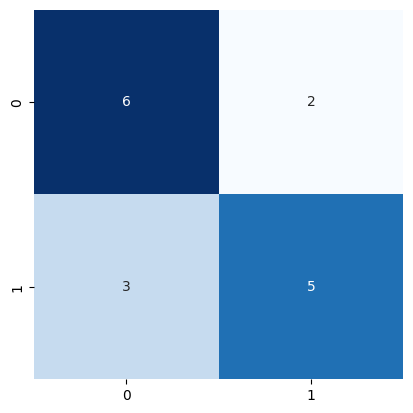

In [108]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(orignal, prediction)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)